In [21]:
!python3 -m pip install torch
!python3 -m pip install matplotlib
!python3 -m pip install -U scikit-learn
!python3 -m pip install scikit-learn
!python3 -m pip install pandas
!python3 -m pip install numpy
!python3 -m pip install Adam
!python3 -m pip install cv2
!python3 -m pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2
Defaulting to user installation because normal site-packages is not writeable


In [32]:
import zipfile
    	
fantasy_zip = zipfile.ZipFile('./archive.zip')
fantasy_zip.extractall('./')
fantasy_zip.close()

In [44]:
!ls

archive.zip  captions.txt  Images


In [46]:
# 데이터 확인

import glob
import matplotlib.pyplot as plt

from PIL import Image

# 데이터셋에 포함된 파일명을 불러옴
imgs = glob.glob("./Images/*.jpg")
print(imgs[0:10])

['./Images/3245070961_8977fdd548.jpg', './Images/491405109_798222cfd0.jpg', './Images/369047365_35476becc9.jpg', './Images/2893238950_8a027be110.jpg', './Images/3529211822_1dabdb3a9c.jpg', './Images/3189941492_a3f4347b1a.jpg', './Images/3694071771_ce760db4c7.jpg', './Images/3644142276_caed26029e.jpg', './Images/3544803461_a418ca611e.jpg', './Images/1225443522_1633e7121f.jpg']


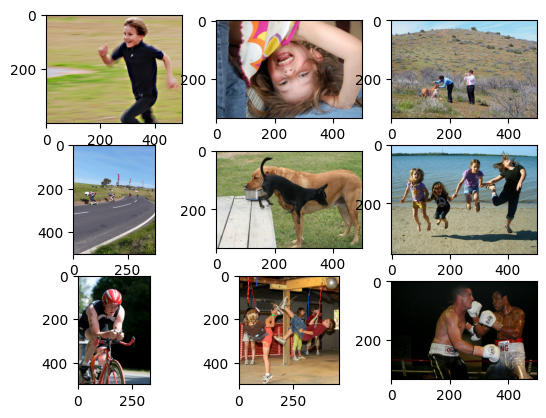

In [47]:
# 이미지 9개를 표기
for i in range(9):
   img = Image.open(imgs[i])
   plt.subplot(3, 3, i+1)
   plt.imshow(img)
plt.show()

In [60]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [63]:
!apt-get -y install libgl1-mesa-glx

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [62]:
# RGB를 LAB로 변환하는 함수
import cv2
import numpy as np

from torch.utils.data.dataset import Dataset

# RGB를 LAB으로 변환
def rgb2lab(rgb):
   return cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)

# LAB를 RGB로 변환합니다
def lab2rgb(lab):
   return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

ImportError: libGL.so.1: cannot open shared object file: No such file or directory

In [14]:
# 학습용 데이터셋 정의
# 학습에 이용할 데이터셋 객체
class AutoColoring(Dataset):
   def __init__(self):  # ❶ 데이터셋의 초기화 함수
       self.data = glob.glob("/content/drive/MyDrive/Colab Notebooks/data/CH09/*.jpg")

   def __len__(self):   # ❷ 사용 가능한 데이터의 개수를 반환하는 함수
       return len(self.data)

   def __getitem__(self, i): # ❸ 데이터를 호출하는 함수
       # RGB 이미지를 불러옴
       rgb = np.array(Image.open(self.data[i]).resize((256, 256)))
       # LAB로 변환
       lab = rgb2lab(rgb)
       
       # 파이토치는 채널이 가장 앞에 와야 하므로 transpose
       lab = lab.transpose((2, 0, 1)).astype(np.float32)

       return lab[0], lab[1:]

NameError: name 'Dataset' is not defined

In [15]:
# 모델 정의하기 : low 레벨 특징 추출기 정의
import torch
import torch.nn as nn


class LowLevel(nn.Module):
   def __init__(self):
       # 로 레벨 특징 추출기를 구성하는 층의 정의
       super(LowLevel, self).__init__()

       self.low1 = nn.Conv2d(1, 64, 
                             kernel_size=3, stride=2, padding=1)
       self.lb1 = nn.BatchNorm2d(64)
       self.low2 = nn.Conv2d(64, 128, 
                             kernel_size=3, stride=1, padding=1)
       self.lb2 = nn.BatchNorm2d(128)
       self.low3 = nn.Conv2d(128, 128, 
                             kernel_size=3, stride=2, padding=1)
       self.lb3 = nn.BatchNorm2d(128)
       self.low4 = nn.Conv2d(128, 256, 
                             kernel_size=3, stride=1, padding=1)
       self.lb4 = nn.BatchNorm2d(256)
       self.low5 = nn.Conv2d(256, 256, 
                             kernel_size=3, stride=2, padding=1)
       self.lb5 = nn.BatchNorm2d(256)
       self.low6 = nn.Conv2d(256, 512, 
                             kernel_size=3, stride=1, padding=1)
       self.lb6 = nn.BatchNorm2d(512)

       self.sigmoid = nn.Sigmoid()
   def forward(self, x):
       # 기본 블록 구성
       low = self.low1(x)        #  ❶합성곱
       low = self.lb1(low)       #  ❷배치 정규화
       low = self.sigmoid(low)   #  ❸시그모이드

       low = self.low2(low)
       low = self.lb2(low)
       low = self.sigmoid(low)

       low = self.low3(low)
       low = self.lb3(low)
       low = self.sigmoid(low)

       low = self.low4(low)
       low = self.lb4(low)
       low = self.sigmoid(low)

       low = self.low5(low)
       low = self.lb5(low)
       low = self.sigmoid(low)
       
       low = self.low6(low)
       low = self.lb6(low)
       low = self.sigmoid(low)

       return low

In [16]:
# 모델 정의하기 : 미들 레벨 특징 추출기 정의
class MidLevel(nn.Module):
   def __init__(self):
       # 미들 레벨 특징 추출기를 구성하는 층의 정의
       super(MidLevel, self).__init__()

       self.mid1 = nn.Conv2d(512, 512, 
                             kernel_size=3, stride=1, padding=1)
       self.mb1 = nn.BatchNorm2d(512)
       self.mid2 = nn.Conv2d(512, 256, 
                             kernel_size=3, stride=1, padding=1)
       self.mb2 = nn.BatchNorm2d(256)

       self.sigmoid = nn.Sigmoid()

   def forward(self, x):
       # 미들 레벨 특징 추출기의 기본 블록
       mid = self.mid1(x)       #  ❶합성곱
       mid = self.mb1(mid)      #  ❷배치 정규화
       mid = self.sigmoid(mid)  #  ❸시그모이드

       mid = self.mid2(mid)
       mid = self.mb2(mid)
       mid = self.sigmoid(mid)

       return mid

In [17]:
# 모델정의하기 : 글로벌 레벨 특징 추출기
class GlobalLevel(nn.Module):
   def __init__(self):
       super(GlobalLevel, self).__init__()

       self.glob1 = nn.Conv2d(512, 512, 
                              kernel_size=3, stride=2, padding=1)
       self.gb1 = nn.BatchNorm2d(512)
       self.glob2 = nn.Conv2d(512, 512, 
                              kernel_size=3, stride=1, padding=1)
       self.gb2 = nn.BatchNorm2d(512)
       self.glob3 = nn.Conv2d(512, 512, 
                              kernel_size=3, stride=2, padding=1)
       self.gb3 = nn.BatchNorm2d(512)
       self.glob4 = nn.Conv2d(512, 512, 
                              kernel_size=3, stride=1, padding=1)
       self.gb4 = nn.BatchNorm2d(512)

       # 글로벌 레벨 특징 추출기의 MLP층 구성
       # 여기서는 분류기로 사용되는것이 아닌, 
       # 색을 칠하기 위해 사용하는 특징으로 사용
       self.fc1 = nn.Linear(in_features=32768, out_features=1024)
       self.fc2 = nn.Linear(in_features=1024, out_features=512)
       self.fc3 = nn.Linear(in_features=512, out_features=256)

       self.sigmoid = nn.Sigmoid()
   def forward(self, x):
       # 글로벌 레벨 특징 추출기의 기본 블록
       glo = self.glob1(x)         # 합성곱
       glo = self.gb1(glo)         # 배치 정규화
       glo = self.sigmoid(glo)     # 활성화

       glo = self.glob2(glo)
       glo = self.gb2(glo)
       glo = self.sigmoid(glo)

       glo = self.glob3(glo)
       glo = self.gb3(glo)
       glo = self.sigmoid(glo)

       glo = self.glob4(glo)
       glo = self.gb4(glo)
       glo = self.sigmoid(glo)
      
       # 추출된 특징을 1차원으로 펼쳐준다
       glo = torch.flatten(glo, start_dim=1)
       glo = self.fc1(glo)
       glo = self.sigmoid(glo)
       glo = self.fc2(glo)
       glo = self.sigmoid(glo)
       glo = self.fc3(glo)
       glo = self.sigmoid(glo)

       return glo

In [18]:
# 모델 정의하기 : 컬러라이제이션 네트워크 정의
class Colorization(nn.Module):
   def __init__(self):
       super(Colorization, self).__init__()
       # Colorization 네트워크 구성에 필요한 층의 정의

       # ❶업샘플링 커널:3 스트라이드:1 패딩:1
       self.color1 = nn.ConvTranspose2d(256, 128, 3, 1, 1)
       self.cb1 = nn.BatchNorm2d(128)
       
       # ❷업샘플링 커널:2 스트라이드:2 패딩:0
       self.color2 = nn.ConvTranspose2d(128, 64, 2, 2)
       self.cb2 = nn.BatchNorm2d(64)
       
       self.color3 = nn.ConvTranspose2d(64, 64, 3, 1, 1)
       self.cb3 = nn.BatchNorm2d(64)
       self.color4 = nn.ConvTranspose2d(64, 32, 2, 2)
       self.cb4 = nn.BatchNorm2d(32)
       self.color5 = nn.ConvTranspose2d(32, 2, 2, 2)

       self.sigmoid = nn.Sigmoid()
   def forward(self, x):
       color = self.color1(x)
       color = self.cb1(color)
       color = self.sigmoid(color)
       color = self.color2(color)
       color = self.cb2(color)
       color = self.sigmoid(color)
       color = self.color3(color)
       color = self.cb3(color)
       color = self.sigmoid(color)
       color = self.color4(color)
       color = self.cb4(color)
       color = self.sigmoid(color)
       color = self.color5(color)

       return color

In [19]:
# 자동채색 모델 정의
class AutoColoringModel(nn.Module):
   def __init__(self):
       super(AutoColoringModel, self).__init__()

       # 로 레벨 특징 추출기
       self.low = LowLevel()
       # 미들 레벨  특징 추출기
       self.mid = MidLevel()
       # 글로벌 레벨 특징 추출기
       self.glob = GlobalLevel()

       # 특징 합치기
       self.fusion = nn.Conv2d(512, 256, 
                               kernel_size=3, stride=1, padding=1)
       
       # 색 입히기
       self.color = Colorization()

       # 활성화 함수
       self.sigmoid = nn.Sigmoid()
   def forward(self, x):
       # ❶로 레벨 특징 추출기로 입력
       low = self.low(x)

       # 로 레벨 특징 추출기의 출력을 넣어줌
       mid = self.mid(low)
       glo = self.glob(low)

       # ❷글로벌 레벨 특징 추출기의 출력을 미들 레벨 특징 추출기의
       # 출력 크기가 되도록 반복
       fusion = glo.repeat(1, mid.shape[2]*mid.shape[2])
       fusion = torch.reshape(
           fusion, (-1, 256, mid.shape[2], mid.shape[2]))
       # ❸글로벌 레벨 특징 추출기의 특징과 미들 레벨 특징 추출기의 특징을 결합
       fusion = torch.cat([mid, fusion], dim=1)
       fusion = self.fusion(fusion)
       fusion = self.sigmoid(fusion)

       # ❹컬러라이제이션 네크워크
       color = self.color(fusion)

       return color

In [20]:
# 모델 학습하기
import tqdm

from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

# ➊모델 정의
model = AutoColoringModel().to(device)


# 데이터 정의
dataset = AutoColoring()
loader = DataLoader(dataset, batch_size=32, shuffle=True)
optim = Adam(params=model.parameters(), lr=0.01)


# 학습 루프 정의
for epoch in range(200):
   iterator = tqdm.tqdm(loader)
   for L, AB in iterator:
       # ➋L 채널은 흑백 이미지 이므로 채널 차원을 확보해야 함
       L = torch.unsqueeze(L, dim=1).to(device)
       optim.zero_grad()
      
       # ➌ A, B 채널을 예측
       pred = model(L)
      
       # ➍손실 계산과 오차 역전파
       loss = nn.MSELoss()(pred, AB.to(device))
       loss.backward()
       optim.step()

       iterator.set_description(f"epoch:{epoch} loss:{loss.item()}")

# ➎모델 가중치 저장
torch.save(model.state_dict(), "AutoColor.pth")

NameError: name 'AutoColoring' is not defined

In [ ]:
# 모델 성능 평가하기
# ➊결과 비교를 위한 실제 이미지
# pyplot의 이미지 형식에 맞추기 위한 약간의 변형이 필요함
test_L, test_AB = dataset[0]
test_L = np.expand_dims(test_L, axis=0)
real_img = np.concatenate([test_L, test_AB])
real_img = real_img.transpose(1, 2, 0).astype(np.uint8)
real_img = lab2rgb(real_img)

# 모델이 예측한 결과
with torch.no_grad():
   # 모델 가중치 불러오기
   model.load_state_dict(
       torch.load("AutoColor.pth", map_location=device))

   # ➋모델의 예측값 계산
   input_tensor = torch.tensor(test_L)
   input_tensor = torch.unsqueeze(input_tensor, dim=0).to(device)
   pred_AB = model(input_tensor)

   # ➌pyplot의 이미지 형식에 맞추기 위한 약간의 변형이 필요함
   pred_LAB = torch.cat([input_tensor, pred_AB], dim=1)
   pred_LAB = torch.squeeze(pred_LAB)
   pred_LAB = pred_LAB.permute(1, 2, 0).cpu().numpy()
   pred_LAB = lab2rgb(pred_LAB.astype(np.uint8))

# ➍실제와 예측값의 비교
plt.subplot(1, 2, 1)
plt.imshow(real_img)
plt.title("real image")
plt.subplot(1, 2, 2)
plt.imshow(pred_LAB)
plt.title("predicted image")
plt.show()